# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

import keras
from keras.preprocessing.image import ImageDataGenerator 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30 #will experiment with the size below
total_frames = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(frames_to_sample,frame_size,source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,total_frames-1,frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
    x = frames_to_sample 
    y = frame_size
    z = frame_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized = resize(image,(y,z))
                    
                    norm = resized/127.5-1 #Normalize data
                          
                    batch_data[folder,idx,:,:,0] = (norm[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (norm[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (norm[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized = resize(image,(y,z))
                    
                    norm = resized/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (norm[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (norm[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (norm[:,:,2]) #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [6]:
def plot(exp):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(exp.history['loss'])   
    axes[0].plot(exp.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(exp.history['categorical_accuracy'])   
    axes[1].plot(exp.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Model 1 - taking frame size as 120*120 and #Epochs = 15
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

# 5 gestures 5 classes
model.add(Dense(5, activation = 'softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [28]:
#Having learning rate as 0.01
optimiser = optimizers.Adam(lr = 0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_11 (Bat  (None, 15, 60, 60, 64)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
frames_to_sample = 30
frame_size = 120

train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size, val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
exp= model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15


2022-11-20 15:58:27.346570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 654.7301 - categorical_accuracy: 0.2640Source path =  /home/datasets/Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: val_loss improved from inf to 211.05571, saving model to model_init_2022-11-2015_57_52.945235/model-00001-654.73010-0.26395-211.05571-0.20000.h5
23/23 [==============================] - 201s 9s/step - loss: 654.7301 - categorical_accuracy: 0.2640 - val_loss: 211.0557 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 4.0365 - categorical_accuracy: 0.2899
Epoch 00002: val_loss improved from 211.05571 to 19.67479, saving model to model_init_2022-11-2015_57_52.945235/model-00002-4.03647-0.28986-19.67479-0.20000.h5
23/23 [==============================] - 35s 2s/step - loss: 4.0365 - categorical_accuracy: 0.2899 - val_loss: 19.6748 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/15
23/23 [==============================] - ETA:

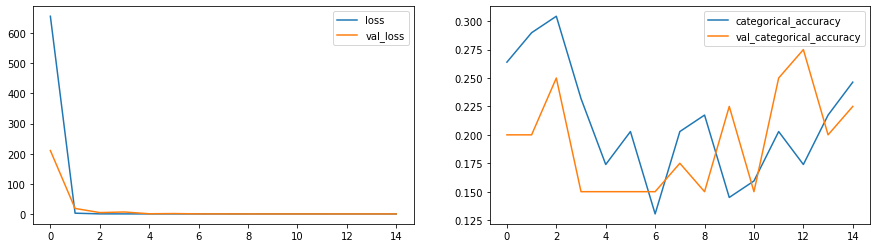

In [18]:
plot(exp)

* Loss stabilisises after 3 epochs
* Very low accuracy in both train & val


### Model 2 
**Architecture can be changed - Adding 1 more convolution and decreasing the Learning rate**

In [35]:
#Architecture

model2 = Sequential()

model2.add(Conv3D(8, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))

model2.add(Conv3D(16, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(32, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.3))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))

# 5 gestures 5 classes
model2.add(Dense(5, activation = 'softmax'))

In [52]:
#Defining params batch size frame size
#trying the base model with frame size 120*120 & total 30 frames
frame_size = 120
frames_to_sample = 30 
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [53]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [54]:
#Steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
optimiser = optimizers.Adam(lr = 0.001) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 30, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_13 (Bat  (None, 30, 60, 60, 16)  

In [56]:
#Model fit 
print("Total Params:", model2.count_params())
exp2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 592101
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.3673 - categorical_accuracy: 0.3047 Source path =  /home/datasets/Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: val_loss improved from inf to 1.43147, saving model to model_init_2022-11-2016_28_42.043591/model-00001-2.36731-0.30468-1.43147-0.39000.h5
23/23 [==============================] - 275s 12s/step - loss: 2.3673 - categorical_accuracy: 0.3047 - val_loss: 1.4315 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.6824 - categorical_accuracy: 0.3478
Epoch 00002: val_loss did not improve from 1.43147
23/23 [==============================] - 41s 2s/step - loss: 1.6824 - categorical_accuracy: 0.3478 - val_loss: 2.0608 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.5967 - 

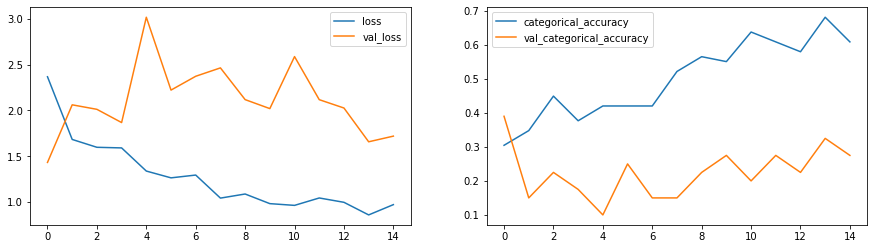

In [57]:
plot(exp2)

* By adding more layers we do see the tarining accuracy improved significantly
* Validation accuracy is low , clearly we have the model overfitting(may be we can increase the batch size)
* Losses doesn't stablize in 15 epochs maybe we can add more


### Model 3 
**Changing #Epochs to 20 and #batch size to 10**

In [58]:

model3 = Sequential()

model3.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,160,160,3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv3D(256, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(500, activation='relu'))
model3.add(Dropout(0.2))

# 5 gestures 5 classes
model3.add(Dense(5, activation = 'softmax'))

In [59]:
#Defining params batch size frame size
#trying the base model with frame size 120*120 & total 30 frames
frame_size = 160
frames_to_sample = 30 
batch_size = 10
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [60]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [61]:
#Steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [62]:
optimiser = optimizers.Adam(lr = 0.001) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_24 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 80, 80, 64)    55360     
                                                                 
 batch_normalization_25 (Bat  (None, 15, 80, 80, 64)  

In [63]:
#Model fit 
num_epochs = 20
print("Total Params:", model3.count_params())
exp3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 27270213
Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 7.3587 - categorical_accuracy: 0.2534Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.60960, saving model to model_init_2022-11-2016_28_42.043591/model-00001-7.35867-0.25339-1.60960-0.24000.h5
67/67 [==============================] - 228s 3s/step - loss: 7.3587 - categorical_accuracy: 0.2534 - val_loss: 1.6096 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
41/67 [=================>............] - ETA: 22s - loss: 1.4646 - categorical_accuracy: 0.4065
Epoch 00002: val_loss did not improve from 1.60960
67/67 [==============================] - 100s 2s/step - loss: 1.4427 - categorical_accuracy: 0.4030 - val_loss: 3.5516 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.5283 - categorical_accura

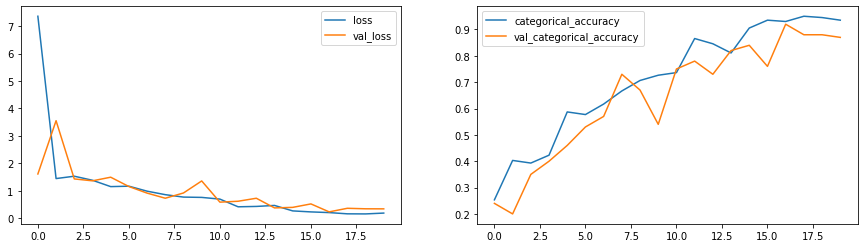

In [64]:
plot(exp3)

* Model performance significantly improved we do see better accuracy for both train and validation
* Losses stablized after 15 Epochs
* Trade off is that we have huge number of trainable parameters which increases time and memory
* Let's increase batch size by a bit and decrease number of epochs a bit 

### Model 4
**Increase batch size and decrease number of epochs to reduce memory usage and making training time fast**

In [65]:

model4 = Sequential()

model4.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,160,160,3)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv3D(256, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(1000, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(500, activation='relu'))
model4.add(Dropout(0.2))

# 5 gestures 5 classes
model4.add(Dense(5, activation = 'softmax'))

In [66]:
#Defining params batch size frame size
#trying the base model with frame size 120*120 & total 30 frames
frame_size = 160
frames_to_sample = 30 
batch_size = 15
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [69]:
#Can change Learning rate from here
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [70]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [71]:
optimiser = optimizers.Adam(lr = 0.001) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_28 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 80, 80, 64)    55360     
                                                                 
 batch_normalization_29 (Bat  (None, 15, 80, 80, 64)  

In [72]:
#Model fit 
num_epochs = 15
print("Total Params:", model4.count_params())
exp4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 27270213
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.6014 - categorical_accuracy: 0.3185
Epoch 00001: saving model to model_init_2022-11-2016_28_42.043591/model-00001-1.60143-0.31852-2.32631-0.19000.h5
45/45 [==============================] - 58s 1s/step - loss: 1.6014 - categorical_accuracy: 0.3185 - val_loss: 2.3263 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.4951 - categorical_accuracy: 0.3556
Epoch 00002: saving model to model_init_2022-11-2016_28_42.043591/model-00002-1.49515-0.35556-1.45258-0.29000.h5
45/45 [==============================] - 58s 1s/step - loss: 1.4951 - categorical_accuracy: 0.3556 - val_loss: 1.4526 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.3219 - categorical_accuracy: 0.4593
Epoch 00003: saving model to model_init_2022-11-2016_28_42.043591/model-00003-1.32194-0.45926-2.00611

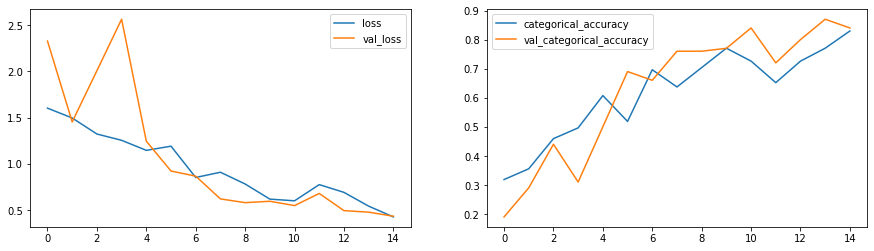

In [73]:
plot(exp4)

* Training time is faster now
* Not enough change in accuracy for both test and train 
* Losss stablised at 15 Epoch

### Model 5
**Changing the Learning rate and decreasing frame size per video & batch size 15**

In [88]:

model5 = Sequential()

model5.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,100,100,3)))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv3D(256, kernel_size = (3,3,3),padding='same'))
model5.add(BatchNormalization())
model5.add(Activation("relu"))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(1000, activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(500, activation='relu'))
model5.add(Dropout(0.2))

# 5 gestures 5 classes
model5.add(Dense(5, activation = 'softmax'))

In [89]:
#Defining params batch size frame size
#trying the base model with frame size 120*120 & total 30 frames
frame_size = 100
frames_to_sample = 30 
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [90]:

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [91]:
#Steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [92]:
optimiser = optimizers.Adam(lr = 0.005) #Using Learning rate as 0.01 and Adam optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 30, 100, 100, 32)  2624      
                                                                 
 batch_normalization_48 (Bat  (None, 30, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 activation_48 (Activation)  (None, 30, 100, 100, 32)  0         
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 15, 50, 50, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 15, 50, 50, 64)    55360     
                                                                 
 batch_normalization_49 (Bat  (None, 15, 50, 50, 64) 

In [93]:
#Model fit 
print("Total Params:", model5.count_params())
exp5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 10886213
Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 20.0207 - categorical_accuracy: 0.2489Source path =  /home/datasets/Project_data/val ; batch size = 15
Batch:  7 Index: 15

Epoch 00001: saving model to model_init_2022-11-2016_28_42.043591/model-00001-20.02066-0.24887-19.81154-0.25000.h5
45/45 [==============================] - 154s 3s/step - loss: 20.0207 - categorical_accuracy: 0.2489 - val_loss: 19.8115 - val_categorical_accuracy: 0.2500 - lr: 0.0050
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.6638 - categorical_accuracy: 0.2593
Epoch 00002: saving model to model_init_2022-11-2016_28_42.043591/model-00002-1.66376-0.25926-8.98319-0.27143.h5
45/45 [==============================] - 45s 1s/step - loss: 1.6638 - categorical_accuracy: 0.2593 - val_loss: 8.9832 - val_categorical_accuracy: 0.2714 - lr: 0.0050
Epoch 3/15
45/45 [==============================]

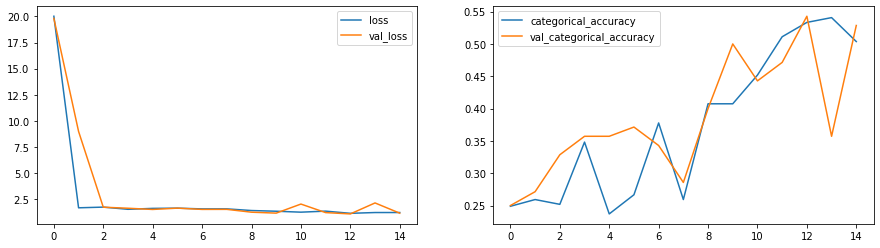

In [94]:
plot(exp5)

* By reducing frame size and Learning rate we notice the accuracy decreased to around 50% from 90%
* Not an ideal model for real time

### Model 6
**Learning rate = 0.001 & image size 120*120 & 20 Epochs & batch size 12**

In [18]:

model6 = Sequential()

model6.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.2))

model6.add(Conv3D(256, kernel_size = (3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation("relu"))
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())

model6.add(Dense(1000, activation='relu'))
model6.add(Dropout(0.2))

model6.add(Dense(500, activation='relu'))
model6.add(Dropout(0.2))

# 5 gestures 5 classes
model6.add(Dense(5, activation = 'softmax'))

In [19]:
#Defining params batch size frame size
#trying the base model with frame size 120*120 & total 30 frames
frame_size = 120
frames_to_sample = 30 
batch_size = 12
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [20]:

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [21]:
#Steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
optimiser = optimizers.Adam(lr = 0.001) #Using Learning rate as 0.01 and Adam optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization_3 (Batc  (None, 30, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_4 (Batc  (None, 15, 60, 60, 64)  

In [25]:
#Model fit 
num_epochs = 20
print("Total Params:", model6.count_params())
exp6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 14214213
Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 5.2920 - categorical_accuracy: 0.3379Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12

Epoch 00001: saving model to model_init_2022-11-2115_14_24.214734/model-00001-5.29198-0.33786-1.68267-0.17000.h5
56/56 [==============================] - 160s 3s/step - loss: 5.2920 - categorical_accuracy: 0.3379 - val_loss: 1.6827 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.4502 - categorical_accuracy: 0.3631
Epoch 00002: saving model to model_init_2022-11-2115_14_24.214734/model-00002-1.45023-0.36310-2.90764-0.16667.h5
56/56 [==============================] - 41s 735ms/step - loss: 1.4502 - categorical_accuracy: 0.3631 - val_loss: 2.9076 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/20
56/56 [==============================] -

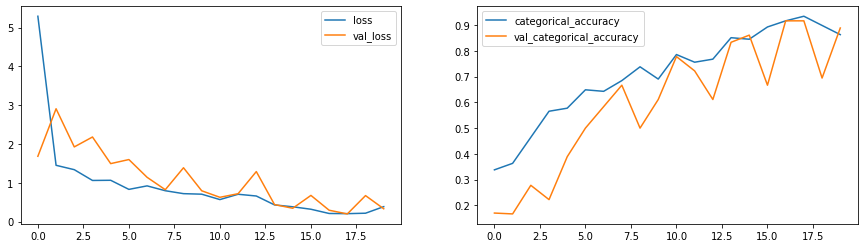

In [26]:
plot(exp6)

* Training accuracy reached around 90%
* Validation accuracy is not stable

### Model 7 
**Using CNN + RNN Combination (Tranfer Learning)**


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow
import keras
from keras import optimizers
#from tensorflow.keras import optimizers

In [9]:
batch_size = 10
y = 160 # changing image crop size as mobilenet application expects size to be one of [128, 160, 192, 224]
z = 160

In [10]:
mn = keras.applications.mobilenet.MobileNet(include_top = False, weights='imagenet',input_shape=(160, 160, 3))

17235968/17225924 [==============================] - 1s 0us/step


In [11]:
model7 = Sequential()

model7.add(TimeDistributed(mn, input_shape = (30,160,160,3)))

model7.add(TimeDistributed(Flatten()))

model7.add(GRU(64,return_sequences=False))

model7.add(Dense(256))
model7.add(Activation("relu"))
model7.add(Dropout(0.3))

model7.add(Dense(5, activation = 'softmax'))

In [12]:
#Optimizer

opt = tensorflow.keras.optimizers.SGD(lr=0.001, decay=0.00001, momentum=0.8, nesterov=True)
model7.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 5, 5, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 25600)        0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)                4927872   
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [13]:
#Defining params batch size frame size
#trying the base model with frame size 160*160 & total 30 frames
frame_size = 160
frames_to_sample = 30 
batch_size = 15
train_generator = generator(frames_to_sample,frame_size,train_path, train_doc, batch_size)
val_generator = generator(frames_to_sample,frame_size,val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
num_epochs = 20
exp7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/20


2022-11-21 15:24:50.000959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.2956 - categorical_accuracy: 0.4842Source path =  /home/datasets/Project_data/val ; batch size = 15
Batch:  7 Index: 15

Epoch 00001: val_loss improved from inf to 0.98575, saving model to model_init_2022-11-2115_14_24.214734/model-00001-1.29563-0.48416-0.98575-0.62000.h5
45/45 [==============================] - 181s 4s/step - loss: 1.2956 - categorical_accuracy: 0.4842 - val_loss: 0.9857 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.9806 - categorical_accuracy: 0.6667
Epoch 00002: val_loss improved from 0.98575 to 0.98121, saving model to model_init_2022-11-2115_14_24.214734/model-00002-0.98058-0.66667-0.98121-0.71429.h5
45/45 [==============================] - 50s 1s/step - loss: 0.9806 - categorical_accuracy: 0.6667 - val_loss: 0.9812 - val_categorical_accuracy: 0.7143 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.867

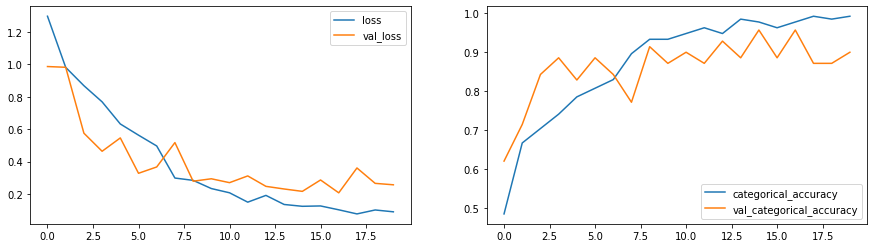

In [17]:
plot(exp7)

* Losses stablizes after 18 Epochs
* Both train and validation accuracy are good with train accuracy nearing 98% & validation around 90%

### Conclusion

* Model 7 is by far the best model when we used CNN & RNN combination with frame size of 160 and #Epochs = 20
* Model 4 & 5 can be also used if we want to use Convolution 3D as both of them had training and validation accuracy near to 90%
